In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import Preprocessing as pp
import scipy
from sklearn import metrics
import warnings
warnings.filterwarnings(action = 'once')

In [2]:
OPEN_FOLDER = '../Data/Temp_Data/'

### Voltage Input data

In [3]:
input_data = pp.openCSVFile('input_drehzahl.csv', OPEN_FOLDER)
input_data

,nsoll_time,nsoll_input_voltage,nsoll_measured
0,0.00000,3.0,3092.446
1,1824.25000,3.0,3092.446
2,1824.26000,5.0,3276.050
3,3048.40000,5.0,3276.050
4,3048.41000,3.0,3092.446
5,4264.85000,3.0,3092.446
6,4264.86000,7.5,3580.525
7,5484.76000,7.5,3580.525
8,5484.77000,3.0,3092.446
9,6704.88000,3.0,3092.446


In [4]:
#use only every second value since two (approximately) same timestamps are provided when a change in the input happens
time_splits = np.array(input_data['nsoll_time'][::2])
END_COLDSTART = 670
START_COOLDOWN = 11250
time_splits[0] = END_COLDSTART
time_splits[-1] = START_COOLDOWN
time_splits

array([  670.  ,  1824.26,  3048.41,  4264.86,  5484.77,  6704.89,
        7919.6 ,  9137.87, 10352.84, 11250.  ])

### Electrical data

In [5]:
el_data = pp.openCSVFile('el_measures_1B.csv', OPEN_FOLDER)
el_data['el_power'] = el_data['el_spannung'] * el_data['el_stromstaerke']
el_data

,el_time_measures,el_stromstaerke,el_spannung,el_power
0,0,-0.750000,235.656738,-176.742554
1,1,-5.859375,-337.524414,1977.682114
2,2,5.671875,336.547852,1908.857346
3,3,-3.375000,-337.585449,1139.350891
4,4,3.796875,336.181641,1276.439667
...,...,...,...,...
12227,12227,4.007812,-338.195801,-1355.425358
12228,12228,-3.656250,337.280273,-1233.181000
12229,12229,3.679688,-337.646484,-1242.433548
12230,12230,-4.570312,337.036133,-1540.360451


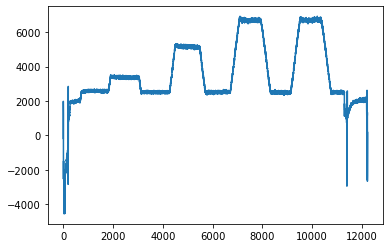

In [6]:
plt.plot(el_data['el_time_measures'], el_data['el_power'])

### Thermal output 

In [7]:
th_data = pp.openCSVFile('th_measures_2A.csv', OPEN_FOLDER)
RHO_KW = 985
C_KW55 = 4181
th_data['th_power'] = th_data['th_VdotKW'] * RHO_KW * C_KW55 * (th_data['th_Tvor'] - th_data['th_Trueck'])
th_data

,th_time_measures,th_TL,th_Trueck,th_Tvor,th_VdotB,th_VdotKW,th_mdotL,th_pL,th_swKuehler,th_power
0,0,16.867188,16.992188,21.494141,0.000005,0.000005,0.063477,1.006211,0.001953,85.845572
1,1,16.820312,17.148438,21.562500,-0.000002,0.000004,0.012695,1.006641,0.016602,76.802419
2,2,16.871094,16.933594,21.455078,0.000008,0.000005,0.076172,1.006094,10.049805,87.727304
3,3,16.812500,17.148438,21.572266,-0.000010,0.000004,0.019043,1.006875,10.221680,74.018932
4,4,16.878906,16.933594,21.435547,0.000013,0.000005,0.063477,1.006211,10.206055,88.851133
...,...,...,...,...,...,...,...,...,...,...
12227,12227,16.582031,16.777344,32.617188,0.000012,0.000005,0.012695,1.005508,10.226562,317.904657
12228,12228,16.527344,16.562500,32.724609,-0.000005,0.000004,0.063477,1.004727,10.206055,286.607410
12229,12229,16.582031,16.816406,32.646484,0.000013,0.000005,0.088867,1.005391,10.223633,317.708662
12230,12230,16.542969,16.582031,32.783203,-0.000007,0.000004,0.025391,1.004805,10.206055,271.075957


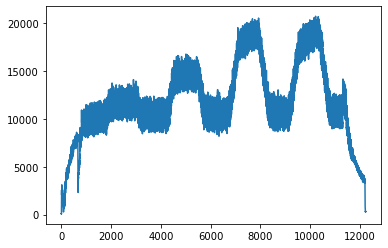

In [8]:
plt.plot(th_data['th_time_measures'], th_data['th_power'])

In [9]:
def findBounds(dataTime, dataValue):
    fig,axs = plt.subplots(round((len(time_splits))/2), 2, figsize = (20,12))
    axs = axs.ravel()
    axs[0].plot(dataTime, dataValue)
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        axs[t+1].plot(dataTime[cut_point_prior:cut_point_post], dataValue[cut_point_prior:cut_point_post])

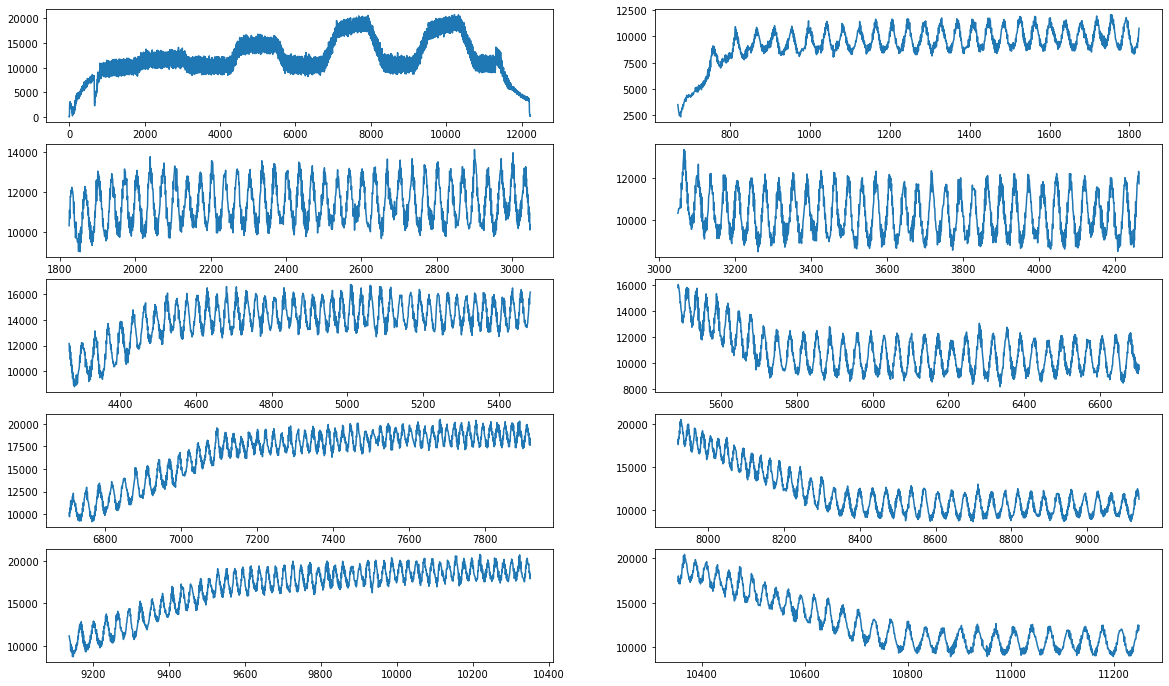

In [10]:
findBounds(th_data['th_time_measures'], th_data['th_power'])

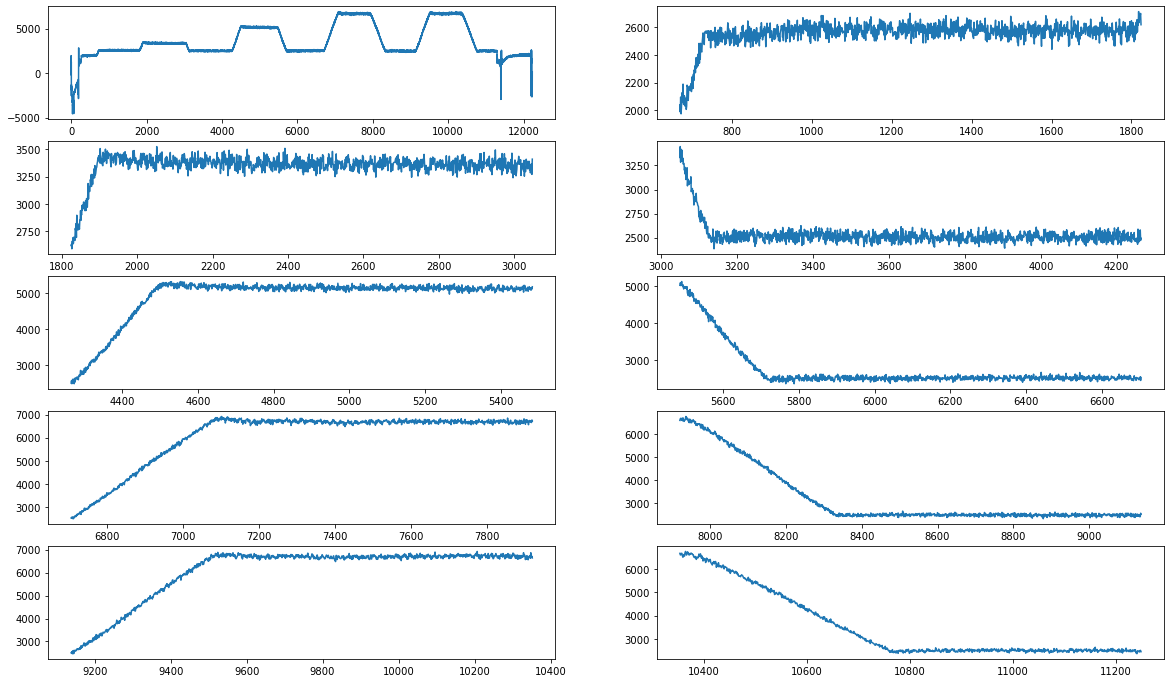

In [11]:
findBounds(el_data['el_time_measures'], el_data['el_power'])

### Approximate using regression method

Formula to approximate is -k* np.exp((-1/tau)* time) +k \
In the approximations by Dustin k was 5900 and tau 330 or 680

In [12]:
def approx_func(x, k, tau):
    return -k* np.exp((-1/tau)*x) +k

In [13]:
def approx(time, values, prior):
    assert len(time) == len(values), 'time and values should have the same length'
    segment_start_value = values[prior]
    param_bounds = ([-np.inf, -np.inf], [np.inf, np.inf])
    para_fit, pcov = scipy.optimize.curve_fit(approx_func, time-prior, values- segment_start_value, bounds=param_bounds)
    k_best = para_fit[0]
    tau_best = para_fit[1]
    return k_best, tau_best

In [14]:
def allApproximation(dataTime, dataValue):
    fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
    axs = axs.ravel()
    approximations = np.full(shape = len(dataTime), fill_value= np.nan)
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = dataTime[cut_point_prior:cut_point_post]
        value_segment = dataValue[cut_point_prior:cut_point_post]
       
        k_best, tau_best = approx(dataTime[cut_point_prior:cut_point_post],
                                  dataValue[cut_point_prior:cut_point_post],
                                  cut_point_prior)
        
        segment_approximation = approx_func(time_segment-cut_point_prior, k_best, tau_best)+dataValue[cut_point_prior]
        axs[t].plot(time_segment, value_segment)
        axs[t].plot(time_segment, segment_approximation)
        approximations[time_segment] = segment_approximation
    
    axs[-1].plot(dataTime, dataValue)
    axs[-1].plot(dataTime, approximations)
    return approximations

C:\Users\FlorianLeiser\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\FlorianLeiser\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\FlorianLeiser\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\FlorianLeiser\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\FlorianLeiser\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


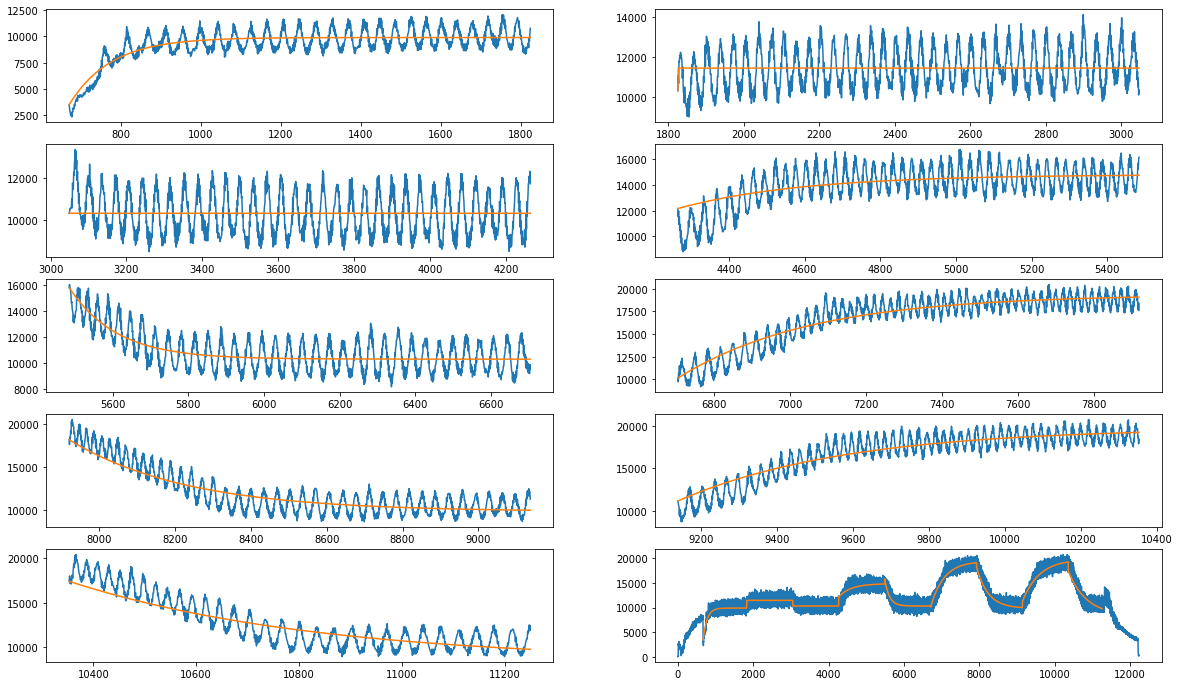

In [15]:
th_data['th_approx'] = allApproximation(th_data['th_time_measures'], th_data['th_power'])

C:\Users\FlorianLeiser\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\FlorianLeiser\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


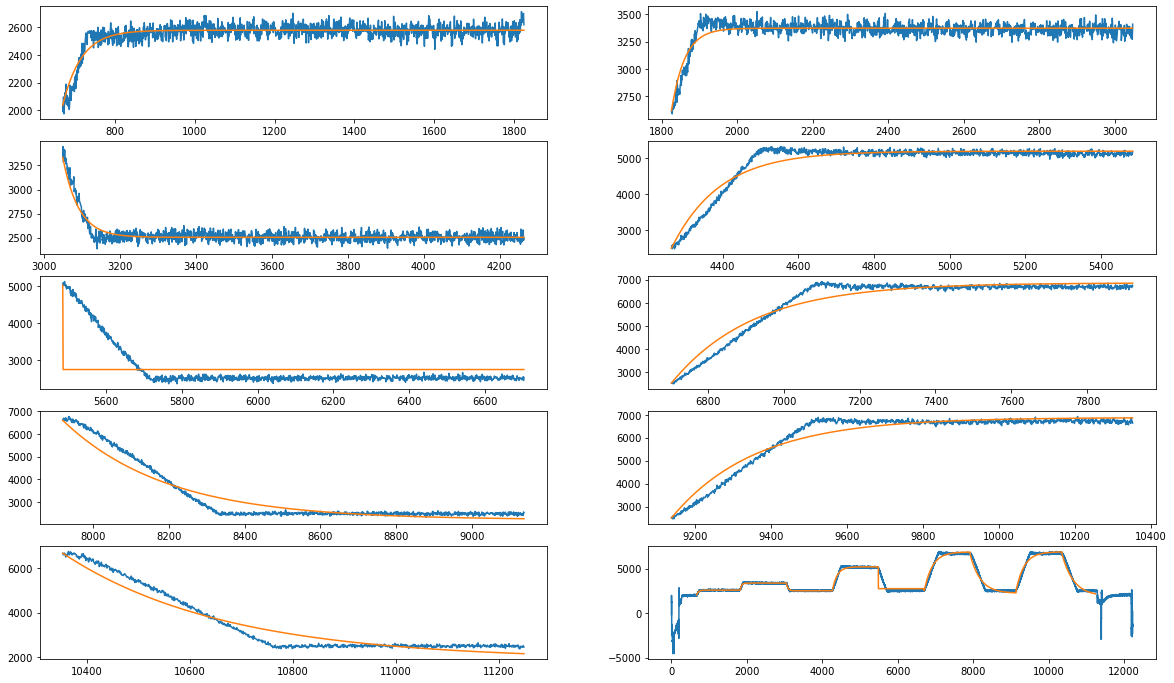

In [16]:
el_data['el_approx'] = allApproximation(el_data['el_time_measures'], el_data['el_power'])

In [17]:
def measureDifference(data, value_header, approx_header):
    R_SQUARED = True
    RSME = True
    
    data = data[data[approx_header].notnull()]
    values = data[value_header]
    approx = data[approx_header]
    
    if RSME:
        rms = metrics.mean_squared_error(values, approx, squared=False)
        print('The RMSE is %5.3f' %rms)
    if R_SQUARED:
        r2 = metrics.r2_score(values, approx)
        print('The R2-score is %5.3f' %r2)

In [18]:
measureDifference(el_data, 'el_power', 'el_approx')

The RMSE is 296.760
The R2-score is 0.967
